## Szeregi czasowe i sieci neuronowe
Utwórz 3 rodzaje sieci

(part1) - poprzednie ćwiczenia
- sieć gęsta
- sieć konwolucyjna

(part2) - 1 punkty projektowe
- Sieć rekurencyjna


(part3) - 2 punkty

RNN dla danych tekstowych



**Problemem do rozwiązania jest predykcja temperatury powietrza za  24 godziny (1 wartość) w mieście Jena**


Pobierz dane. (Orygianlne źródło danych:
www.bgc-jena.mpg.de/wetter )

Dane zawierają 14 różnych wartości, które były mierzone co 10 minut w latach 2009-2016



In [3]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip


In [4]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))


     
# Parsing the data


import numpy as np 
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

raw_data[0] #first row

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

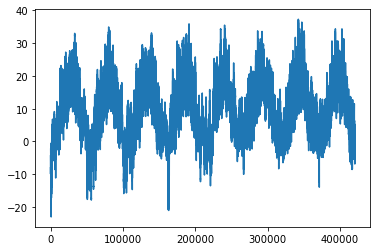

In [5]:

     
# Plotting the temperature timeseries


from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)




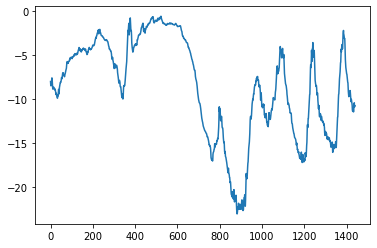

In [6]:
# plot part of the data from 10 first days ( number of samples 60/10*24*10)

plt.plot(range(1440), temperature[:1440])


     

In [7]:
# Computing the number of samples we'll use for each data split


num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)


num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [8]:
temperature

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

In [9]:
raw_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

In [10]:
     
# Preparing the data
# Normalizing the data


mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std


Jak przygotować szeregi czasowe jako wejście do modelu keras

keras.utils.timeseries_dataset_from_array

https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [11]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
print(int_sequence)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))



[0 1 2 3 4 5 6 7 8 9]
[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [12]:

sampling_rate = 6 #Observations will be sampled at one data point per hour
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1) #How many timesteps in the future the target should be
batch_size = 256


train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


     
# Inspecting the output of one of our datasets


for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Model referencyjny:

Oblicz średni błąd bezwzględny (MAE) jeśli:

temperatury kolejnego dnia są prawdopodobnie bardzo bliskie temperaturom dzisiejszym.



In [13]:

def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")


     

     

Validation MAE: 2.44
Test MAE: 2.62


Utwórz sieć neuronową z warstwami gęstymi aby spróbować rozwiązać problem:




1. Wymiar wejścia powinny wylądać :(length of sequence, raw_data.shape[-1]) 
2. Dodaj warstwę spłaszczającą (flatten) na początku sieci 
3. Dodaj warstwy gęste z odpowiednimi funkcjami aktywacji
4. Funkcja kosztu - mse, metryka -mae.
5. można użyć callback do zapisania najlepszych modeli
6. wytrenuj model przez minimum 10 epok, zapisz historię i utwóz wykresy wyników, dodaj ewaluacje na testowym zbiorze
7. Czy model jest lepszy niż model referencyjny ? Dlaczego?

In [14]:


from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


    


Epoch 1/10
819/819 [==============================] - 29s 34ms/step - loss: 13.5152 - mae: 2.8388 - val_loss: 11.6155 - val_mae: 2.6742
Epoch 2/10
819/819 [==============================] - 30s 36ms/step - loss: 9.5658 - mae: 2.4345 - val_loss: 11.2915 - val_mae: 2.6560
Epoch 3/10
819/819 [==============================] - 23s 28ms/step - loss: 8.8305 - mae: 2.3408 - val_loss: 9.9934 - val_mae: 2.4997
Epoch 4/10
819/819 [==============================] - 26s 31ms/step - loss: 8.3349 - mae: 2.2750 - val_loss: 10.0573 - val_mae: 2.5030
Epoch 5/10
819/819 [==============================] - 28s 34ms/step - loss: 7.9917 - mae: 2.2269 - val_loss: 10.4933 - val_mae: 2.5634
Epoch 6/10
819/819 [==============================] - 25s 30ms/step - loss: 7.7294 - mae: 2.1911 - val_loss: 10.3737 - val_mae: 2.5486
Epoch 7/10
819/819 [==============================] - 27s 33ms/step - loss: 7.5160 - mae: 2.1568 - val_loss: 10.0805 - val_mae: 2.5112
Epoch 8/10
819/819 [==============================] - 2

 
Plotting results

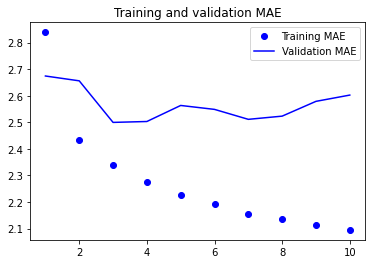

In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


     



Utwórz sieć konwolucyjna

1. Wejście wygląda podobnie jak w poprzedniej warstwie
2. Dodaj kilka warstw 1D Convolution oraz MaxPooling
3. Po ostatniej warstwie Convolution dodaj Global Average Poooling1d https://keras.io/api/layers/pooling_layers/global_average_pooling1d/ 
4. Ostatnia warstwa jest gęsta
5. Funkcja kosztu - mse, metryka -mae.
5. można użyć callback do zapisania najlepszych modeli
6. wytrenuj model przez minimum 10 epok, zapisz historię i utwórz wykresy wyników, dodaj ewaluacje na testowym zbiorze
7. Czy model jest lepszy niż poprzednie modele? Dlaczego?

In [16]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")



Epoch 1/10
819/819 [==============================] - 73s 88ms/step - loss: 23.0492 - mae: 3.7374 - val_loss: 19.0733 - val_mae: 3.4258
Epoch 2/10
819/819 [==============================] - 67s 81ms/step - loss: 15.2224 - mae: 3.0863 - val_loss: 18.1770 - val_mae: 3.4047
Epoch 3/10
819/819 [==============================] - 72s 88ms/step - loss: 13.9400 - mae: 2.9514 - val_loss: 16.5424 - val_mae: 3.2044
Epoch 4/10
819/819 [==============================] - 75s 91ms/step - loss: 13.1715 - mae: 2.8721 - val_loss: 15.6059 - val_mae: 3.0806
Epoch 5/10
819/819 [==============================] - 75s 91ms/step - loss: 12.5778 - mae: 2.8055 - val_loss: 15.2047 - val_mae: 3.0481
Epoch 6/10
819/819 [==============================] - 70s 86ms/step - loss: 12.0646 - mae: 2.7452 - val_loss: 18.6541 - val_mae: 3.4046
Epoch 7/10
819/819 [==============================] - 68s 83ms/step - loss: 11.6402 - mae: 2.6957 - val_loss: 15.8000 - val_mae: 3.0962
Epoch 8/10
819/819 [============================

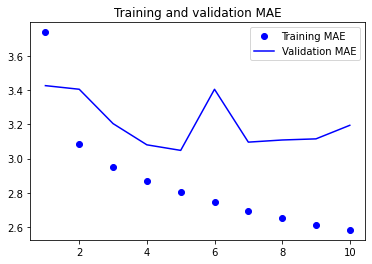

In [17]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


## RNNS (1 punkt)

     
Prostu model LSTM

1. Wejście jest podobne jak w poprzednich sieciach (bez warstwy "spłaszczającej" wejście)
2. Model powinien mieć 1 warstwę LSTM z pewną liczbą komórek. 
3. Dodaj warstwę gęstą jako ostatnią warstwę
4. Funkcja straty: błąd średniokwadratowy (mse), metryka średni błąd bezwzględny (mae).
5. Możesz użyć callbacków do zapisu najlepszego modelu itp.
6. Wytrenuj model przynajmniej 10 epok, zapisz historie i utwórz wykres 
7. Czy wynik jest lepszy niż poprzednich modeli?



In [18]:
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=2)

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
l = layers.LSTM(4)(inputs)
outputs = layers.Dense(1)(l)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop', loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")



     


Epoch 1/10
819/819 [==============================] - 43s 50ms/step - loss: 100.8669 - mae: 8.0517 - val_loss: 73.2991 - val_mae: 6.6460
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 53.9158 - mae: 5.5641 - val_loss: 37.9169 - val_mae: 4.5800
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 30.0216 - mae: 4.0579 - val_loss: 20.1816 - val_mae: 3.3156
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 18.9958 - mae: 3.2352 - val_loss: 12.9935 - val_mae: 2.7223
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 13.9651 - mae: 2.8305 - val_loss: 10.8701 - val_mae: 2.5500
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 11.5792 - mae: 2.6417 - val_loss: 9.9518 - val_mae: 2.4556
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 10.9338 - mae: 2.5762 - val_loss: 9.5807 - val_mae: 2.4117
Epoch 8/10
819/819 [=============================

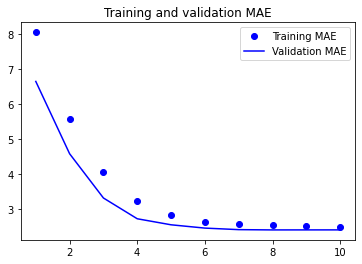

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


Optional:
Utwórz sieć rekurencyjną dwukierunkową 
Wykorzystaj  wrapper Bidirectional (https://keras.io/api/layers/recurrent_layers/bidirectional/)  dla warstwy LSTM. Tworzy on dwie warstwy LSTM w dwóch kierunkach, od początku do końca sekwencji i od  końca do początku.



In [40]:
from keras.layers import Bidirectional


callback = EarlyStopping(monitor='val_loss', patience=2)

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
lstm1 = layers.LSTM(4, return_sequences=True)(inputs)
l = Bidirectional(lstm1 ,shape=(None,120,4))
outputs = layers.Dense(1)(l)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop', loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)



print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")



ValueError: Please initialize `Bidirectional` layer with a `tf.keras.layers.Layer` instance. Received: KerasTensor(type_spec=TensorSpec(shape=(None, 120, 4), dtype=tf.float32, name=None), name='lstm_17/PartitionedCall:1', description="created by layer 'lstm_17'")

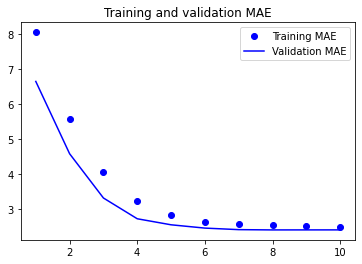

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


## Another possibilities of RNN architectures:

Input: sequences of any length




In [22]:


num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)


     


returns only last output step

In [23]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)



(None, 16)


returns full output sequence


In [24]:

num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)



(None, 120, 16)


Stacking RNN layers

In [25]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Sieci rekurencyjne dla tekstu (2 punkty projektowe)

Pobieranie danych

In [26]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 80.2M    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 80.2M    0  128k    0     0  62008      0  0:22:36  0:00:02  0:22:34 62031
  0 80.2M    0  496k    0     0   158k      0  0:08:37  0:00:03  0:08:34  158k
  1 80.2M    1  944k    0     0   228k      0  0:05:58  0:00:04  0:05:54  228k
  1 80.2M    1 1472k    0     0   287k      0  0:04:45  0:00:05  0:04:40  289k
  2 80.2M    2 2032k    0     0   332k      0  0:04:07  0:00:06  0:04:01  406k
  3 80.2M    3 2608k    0     0   367k      0  0:03:43  0:00:07  0:03:36  496k
  3 80.2M    3 3168k    0     0   391k      0  0:03:30  0:00:08  0:03:22  537k
  4 80.2M    4 3760k    0     0   413k      0  0:03

^C


'rm' is not recognized as an internal or external command,
operable program or batch file.


Przygotowanie danych

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32


base_dir = pathlib.Path("aclImdb")

val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"): # randomly splitdata into train and validation set
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)


In [ ]:


# create keras datasets from files in directiories
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

# potrzebne później do tworzenia  słownika
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [ ]:
label_only_train_ds = train_ds.map(lambda x, y:y)

In [ ]:
for t in label_only_train_ds:
  print(t)
  break

tf.Tensor([1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1], shape=(32,), dtype=int32)


In [ ]:
for t in text_only_train_ds:
  print(t[0])
  print(t[1])
  print(t[2])

  break

tf.Tensor(b"Enchanted April is a tone poem, an impressionist painting, a masterpiece of conveying a message with few words. It has been one of my 10 favorite films since it came out. I continue to wait, albeit less patiently, for the film to come out in DVD format. Apparently, I am not alone.<br /><br />If parent company Amazon's listings are correct, there are many people who want this title in DVD format. Many people want to go to Italy with this cast and this script. Many people want to keep a permanent copy of this film in their libraries. The cast is spectacular, the cinematography and direction impeccable. The film is a definite keeper. Many have already asked. Please add our names to the list.", shape=(), dtype=string)
tf.Tensor(b'In one word... abysmal. I give it one star for the hippie sex scenes and eye candy women, otherwise forget it. Corman\'s worst effort, bar none. Ben Vereen should have had his name permanently stricken from the cast. I cannot believe that this is now g

In [ ]:
for text, label in train_ds:
  print("Text")
  print(text[0])
  print("Label")
  print(label[0])

  break

Text
tf.Tensor(b"Dog Bite Dog isn't going to be for everyone, but I really enjoyed it. Full of slapping, stabbing and shooting (but don't worry \xc2\x96 the lead's a terrible shot), it can best be described as a violent romp through Hong Kong and Cambodia. Edison Cheng plays Pang, a Cambodian assassin in town to kill a barrister. Despite being filthy from his journey, he's almost immediately seated at a huge table in the middle of an obviously expensive restaurant. If this sounds wildly implausible to you, you should probably avoid this film. It acted as my cue to suspend disbelief, and I had a lot more fun for it.<br /><br />Chasing Pang down is Wai (Sam Lee), a young, edgy cop who likes to smack people around almost as much as he likes to smoke. Wai walks a fine line that has Internal Affairs investigating him, and his father, a legendary Good Cop, is in a coma following a drug deal that went south (the implication is that Wai is letting his father take the rap for his own corrupt de

Zamień teskt na sekwencję liczb całkowitych (int)

Utwórz warstwę layers.TextVectorization https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/ z conajmniej 2 argumentami
max_tokens, output_mode (int), output_sequence_length

Wywałaj metodę adapt z powyższej wastwy aby utworzyć słownik wykorzystując teksty ze zbioru treningowego. Bedzie on wykorzystywany do zamiany tekstu na integers

In [ ]:
from tensorflow.keras import layers

max_sequence_length = 600
max_tokens = 20000
text_vectorization =










int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Zbuduj model wykorzystując funkcyjne api
1. Utwórz warstwę wejściową  Iinput layer)
2. Użyj warswy tf.one_hot do zamiany sekwencji  liczb na wektory "one-hot".
2. Utwórz warstwę LSTM która jako wejście przyjmuje sekwencję wektorów one-hot. Możesz dodać dwukierunkowy (bidirectional) wrapper
3. Dodaj warstwę dropout.
4. Ostatnia warstwa powinna być warstwą gęstą z odpowiednią do zadania funkcją aktywacji.
5. Wytrenuj model i dokonaj ewaluacji na zbiorze testowym. Spróbuj osiągnąć minimum 85% dokładnosci na zbiorze testowym.


In [ ]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")


In [ ]:

print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")